In [1]:
#Load Required Libraries:
library(Seurat)
library(SeuratData)
library(SeuratDisk)
library(CellChat)
library(patchwork)
options(stringsAsFactors = FALSE)
library(dplyr)
library(Signac)
library(loomR)
library(scater)

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: igraph

Warning message:
"package 'igraph' was built under R version 4.3.1"

Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.3.1"
Warning message:
"package 'Signac' was built under R version 4.3.1"
Loading required package: R6

Loading required package: hdf5r


Attaching package: 'loomR'


T

In [2]:
x <- read.csv("raw-counts.csv",header=TRUE)
rownames(x) <- x[,1]
x[,1] <- NULL
print(dim(x))
print(x[1:5,1:5])

[1]  6543 14622
                       TSPAN6 DPM1 SCYL3 C1orf112      FGR
AAAGCAAGTTCTGGTA-1_1_1      0    0     0        0 0.000000
AACGTTGTCGACCAGC-1_1_1      0    0     0        0 2.508516
ACCGTAAAGTCGTACT-1_1_1      0    0     0        0 2.540203
ACTTACTAGGTGGGTT-1_1_1      0    0     0        0 0.000000
ACTTACTTCGCAAGCC-1_1_1      0    0     0        0 0.000000


In [3]:
m <- read.csv("metadata.csv",header=TRUE)
rownames(m) <- m[,1]
colnames(m)[1] <- "sample"
print(dim(m))
print(head(m))


[1] 6543   35
                                       sample    orig.ident nCount_RNA
AAAGCAAGTTCTGGTA-1_1_1 AAAGCAAGTTCTGGTA-1_1_1 SeuratProject        854
AACGTTGTCGACCAGC-1_1_1 AACGTTGTCGACCAGC-1_1_1 SeuratProject       2574
ACCGTAAAGTCGTACT-1_1_1 ACCGTAAAGTCGTACT-1_1_1 SeuratProject       1669
ACTTACTAGGTGGGTT-1_1_1 ACTTACTAGGTGGGTT-1_1_1 SeuratProject       1748
ACTTACTTCGCAAGCC-1_1_1 ACTTACTTCGCAAGCC-1_1_1 SeuratProject       1434
AGGGAGTTCTAACTCT-1_1_1 AGGGAGTTCTAACTCT-1_1_1 SeuratProject       1341
                       nFeature_RNA id age gender stage      tissue organism
AAAGCAAGTTCTGGTA-1_1_1          342  1  81  Male   MGUS Bone Marrow    Human
AACGTTGTCGACCAGC-1_1_1         1035  1  81  Male   MGUS Bone Marrow    Human
ACCGTAAAGTCGTACT-1_1_1          652  1  81  Male   MGUS Bone Marrow    Human
ACTTACTAGGTGGGTT-1_1_1          599  1  81  Male   MGUS Bone Marrow    Human
ACTTACTTCGCAAGCC-1_1_1          578  1  81  Male   MGUS Bone Marrow    Human
AGGGAGTTCTAACTCT-1_1_1     

In [4]:
saveRDS(
  CreateSeuratObject(counts=t(x),meta.data=m,project="seurat",min.cells=0,min.features=0),
  "seuratMM.Rds"
)

In [5]:
# Loading Data  -----------------------------------------------------------

Multiple_Myeloma<- readRDS("seuratMM.Rds")
Multiple_Myeloma

An object of class Seurat 
14622 features across 6543 samples within 1 assay 
Active assay: RNA (14622 features, 0 variable features)

In [6]:
Multiple_Myeloma <- NormalizeData(Multiple_Myeloma, normalization.method = "LogNormalize", scale.factor = 10000)

In [60]:
Highly_variable_genes=read.csv("Highly_variable_genes.csv")
#Highly_variable_genes


In [61]:
Feature_names=Highly_variable_genes$X0
clustered_count_df=as.data.frame(Multiple_Myeloma@assays$RNA@counts)
intersected_genes=intersect(rownames(Multiple_Myeloma@assays$RNA@counts),Feature_names)
Multiple_myeloma_cellcaht=subset(x =Multiple_Myeloma , features = intersected_genes)

In [62]:
saveRDS(Multiple_myeloma_cellcaht,"cellchatMM.Rds")


In [63]:
Multiple_m <- readRDS("cellchatMM.Rds")
Multiple_m

An object of class Seurat 
2942 features across 6543 samples within 1 assay 
Active assay: RNA (2942 features, 0 variable features)

In [11]:
# Part I: Data input & processing and initialization of Cell Chat ----------
#1- Create a Cell Chat object

In [64]:
cellchat <- createCellChat(object = Multiple_m , group.by = "celltypist_cell_label_coarse") 
cellchat <- setIdent(cellchat, ident.use = "celltypist_cell_label_coarse") # set "cell_type" as default cell identity
levels(cellchat@idents) # show factor levels of the cell_type
groupSize <- as.numeric(table(cellchat@idents)) # number of cells in each cell group
groupSize

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
The `meta.data` slot in the Seurat object is used as cell meta information 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B-cell lineage B cells DC Endothelial cells HSC/MPP ILC Monocytes pDC Plasma cells T cells 


[1] "B-cell lineage"    "B cells"           "DC"               
 [4] "Endothelial cells" "HSC/MPP"           "ILC"              
 [7] "Monocytes"         "pDC"               "Plasma cells"     
[10] "T cells"

[1]   52  205   36   29   54  376  736   33 1662 3360

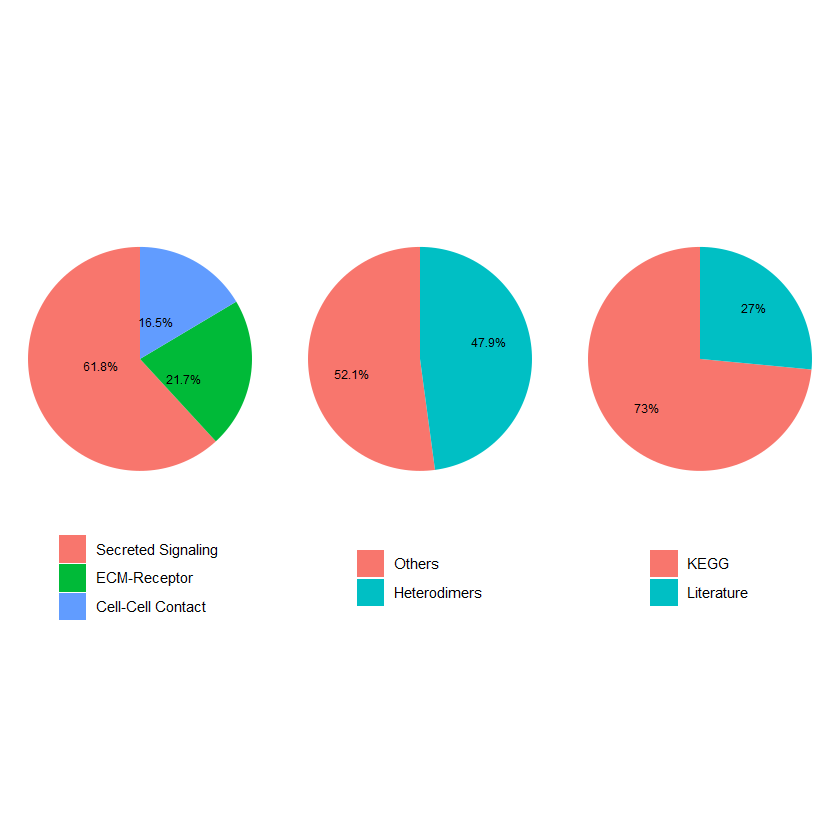

In [65]:
#2- Set the ligand-receptor interaction database(Human)
CellChatDB <- CellChatDB.human # use Cell ChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)

In [66]:
# Show the structure of the database
dplyr::glimpse(CellChatDB$interaction)

Rows: 1,939
Columns: 11
$ interaction_name   <chr> "TGFB1_TGFBR1_TGFBR2", "TGFB2_TGFBR1_TGFBR2", "TGFB…
$ pathway_name       <chr> "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TG…
$ ligand             <chr> "TGFB1", "TGFB2", "TGFB3", "TGFB1", "TGFB1", "TGFB2…
$ receptor           <chr> "TGFbR1_R2", "TGFbR1_R2", "TGFbR1_R2", "ACVR1B_TGFb…
$ agonist            <chr> "TGFb agonist", "TGFb agonist", "TGFb agonist", "TG…
$ antagonist         <chr> "TGFb antagonist", "TGFb antagonist", "TGFb antagon…
$ co_A_receptor      <chr> "", "", "", "", "", "", "", "", "", "", "", "", "",…
$ co_I_receptor      <chr> "TGFb inhibition receptor", "TGFb inhibition recept…
$ evidence           <chr> "KEGG: hsa04350", "KEGG: hsa04350", "KEGG: hsa04350…
$ annotation         <chr> "Secreted Signaling", "Secreted Signaling", "Secret…
$ interaction_name_2 <chr> "TGFB1 - (TGFBR1+TGFBR2)", "TGFB2 - (TGFBR1+TGFBR2)…


In [67]:
# use a subset of CellChatDB for cell-cell communication analysis
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") # Paracrine Autocrine Signaling interactions

In [68]:
# use all CellChatDB for cell-cell communication analysis
# CellChatDB.use <- CellChatDB # simply use the default CellChatDB
# set the used database in the object
cellchat@DB <- CellChatDB.use

In [69]:
#3-Preprocessing the expression data for cell-cell communication analysis
# subset the expression data of signaling genes for saving computation cost
cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
future::plan("multicore", workers=4) # do parallel
cellchat <- identifyOverExpressedGenes(cellchat) #with 20 warnings
cellchat <- identifyOverExpressedInteractions(cellchat) # with warnings 

In [70]:
# # Part II: Inference of cell-cell communication network -------- --------
#1-Compute the communication probability and infer cellular communication network
cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = 0.1) # CellChat uses a statistically robust mean method called ‘tri-mean’ in default , truncated mean is the other option.
cellchat@options$parameter #Parameter_Values_Storage

truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-09-10 22:31:44.247869]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-09-10 22:32:41.087798]"


$type.mean
[1] "truncatedMean"

$trim
[1] 0.1

$raw.use
[1] TRUE

$population.size
[1] FALSE

$nboot
[1] 100

$seed.use
[1] 1

$Kh
[1] 0.5

$n
[1] 1

$distance.use
NULL

$interaction.length
NULL

$spot.size
NULL

$spot.size.fullres
NULL

$k.min
NULL

In [71]:
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 10)


In [72]:
#2-Extract the inferred cellular communication network as a data frame
df.net <- subsetCommunication(cellchat)
View(df.net)


,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,Endothelial cells,B-cell lineage,CCL2,CCR2,0.0045135937,0.00,CCL2_CCR2,CCL2 - CCR2,CCL,Secreted Signaling,KEGG: hsa04060
2,Endothelial cells,DC,CCL2,CCR2,0.0048397195,0.00,CCL2_CCR2,CCL2 - CCR2,CCL,Secreted Signaling,KEGG: hsa04060
3,Endothelial cells,Monocytes,CCL2,CCR2,0.0050898358,0.00,CCL2_CCR2,CCL2 - CCR2,CCL,Secreted Signaling,KEGG: hsa04060
4,Endothelial cells,Plasma cells,CCL2,CCR2,0.0305178629,0.00,CCL2_CCR2,CCL2 - CCR2,CCL,Secreted Signaling,KEGG: hsa04060
5,Endothelial cells,Endothelial cells,CCL2,ACKR1,0.0156000813,0.00,CCL2_ACKR1,CCL2 - ACKR1,CCL,Secreted Signaling,PMID: 26740381
6,Endothelial cells,Endothelial cells,CXCL2,ACKR1,0.0055223490,0.00,CXCL2_ACKR1,CXCL2 - ACKR1,CXCL,Secreted Signaling,PMID: 26740381
7,Monocytes,Endothelial cells,CXCL8,ACKR1,0.0058618588,0.00,CXCL8_ACKR1,CXCL8 - ACKR1,CXCL,Secreted Signaling,PMID: 26740381
8,Endothelial cells,B-cell lineage,CXCL12,CXCR4,0.0889476763,0.00,CXCL12_CXCR4,CXCL12 - CXCR4,CXCL,Secreted Signaling,KEGG: hsa04060
9,Endothelial cells,B cells,CXCL12,CXCR4,0.1411955122,0.00,CXCL12_CXCR4,CXCL12 - CXCR4,CXCL,Secreted Signaling,KEGG: hsa04060


In [74]:
# from T cell and Monocytes to HSCMPP and B cell lieages
df.net1 <- subsetCommunication(cellchat, sources.use = c(9,7), targets.use = c(5,1))
View(df.net1)

,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,Monocytes,B-cell lineage,NAMPT,INSR,0.015491563,0.00,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
2,Plasma cells,B-cell lineage,NAMPT,INSR,0.001206093,0.03,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
3,Monocytes,HSC/MPP,NAMPT,INSR,0.015877963,0.00,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
4,Plasma cells,HSC/MPP,NAMPT,INSR,0.001236624,0.04,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
5,Plasma cells,B-cell lineage,MDK,ITGA4_ITGB1,0.006757498,0.00,MDK_ITGA4_ITGB1,MDK - (ITGA4+ITGB1),MK,Secreted Signaling,PMID: 28356350
6,Plasma cells,HSC/MPP,MDK,ITGA4_ITGB1,0.038558165,0.00,MDK_ITGA4_ITGB1,MDK - (ITGA4+ITGB1),MK,Secreted Signaling,PMID: 28356350


In [76]:
#### CXCL13 expression was found to be strongly induced by the interactions between MM cell lines and microenvironment cells, including BM stromal cells and macrophages.
####Galectins have a role in hematopoietic differentiation, in particular creating specific galectin–glycan interactions between hematopoietic and stromal cells, sustaining the formation of a microenvironmental niche
df.net2<- subsetCommunication(cellchat, signaling = c("MK", "VISFATIN"))
View(df.net2)

,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,B-cell lineage,B-cell lineage,NAMPT,INSR,0.0017230623,0.01,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
2,DC,B-cell lineage,NAMPT,INSR,0.0093032696,0.00,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
3,HSC/MPP,B-cell lineage,NAMPT,INSR,0.0021356132,0.01,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
4,Monocytes,B-cell lineage,NAMPT,INSR,0.0154915632,0.00,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
5,Plasma cells,B-cell lineage,NAMPT,INSR,0.0012060929,0.03,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
6,DC,DC,NAMPT,INSR,0.0040350377,0.00,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
7,Monocytes,DC,NAMPT,INSR,0.0067428911,0.00,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
8,B-cell lineage,HSC/MPP,NAMPT,INSR,0.0017666562,0.03,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838
9,DC,HSC/MPP,NAMPT,INSR,0.0095368124,0.00,NAMPT_INSR,NAMPT - INSR,VISFATIN,Secreted Signaling,PMID: 28490838


In [77]:
#3-Infer the cell-cell communication at a signaling pathway level
cellchat <- computeCommunProbPathway(cellchat)
View(cellchat@netP)
cellchat@netP$pathways   
cellchat@netP[["pathways"]]

$pathways
[1] "CXCL"     "MK"       "VISFATIN" "CCL"     

$prob
, , CXCL

                  B-cell lineage   B cells         DC Endothelial cells
B-cell lineage        0.00000000 0.0000000 0.00000000       0.000000000
B cells               0.00000000 0.0000000 0.00000000       0.000000000
DC                    0.00000000 0.0000000 0.00000000       0.000000000
Endothelial cells     0.08894768 0.1411955 0.04511595       0.005522349
HSC/MPP               0.00000000 0.0000000 0.00000000       0.000000000
ILC                   0.00000000 0.0000000 0.00000000       0.000000000
Monocytes             0.00000000 0.0000000 0.00000000       0.005861859
pDC                   0.00000000 0.0000000 0.00000000       0.000000000
Plasma cells          0.00000000 0.0000000 0.00000000       0.000000000
T cells               0.00000000 0.0000000 0.00000000       0.000000000
                     HSC/MPP        ILC  Monocytes        pDC Plasma cells
B-cell lineage    0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
B cells           0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
DC                0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
Endothelial cells 0.04078696 0.05534213 0.02457903 0.06767461   0.05415228
HSC/MPP           0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
ILC               0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
Monocytes         0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
pDC               0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
Plasma cells      0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
T cells           0.00000000 0.00000000 0.00000000 0.00000000   0.00000000
                     T cells
B-cell lineage    0.00000000
B cells           0.00000000
DC                0.00000000
Endothelial cells 0.08234928
HSC/MPP           0.00000000
ILC               0.00000000
Monocytes         0.00000000
pDC               0.00000000
Plasma cells      0.00000000
T cells           0.00000000

, , MK

                  B-cell lineage    B cells         DC Endothelial cells
B-cell lineage       0.000000000 0.00000000 0.00000000       0.000000000
B cells              0.000000000 0.00000000 0.00000000       0.000000000
DC                   0.000000000 0.00000000 0.00000000       0.000000000
Endothelial cells    0.000000000 0.00000000 0.01869242       0.019421601
HSC/MPP              0.000000000 0.00000000 0.00000000       0.004777845
ILC                  0.000000000 0.00000000 0.00000000       0.000000000
Monocytes            0.000000000 0.00000000 0.00000000       0.000000000
pDC                  0.000000000 0.00000000 0.00000000       0.000000000
Plasma cells         0.006757498 0.01165845 0.01787467       0.018572557
T cells              0.000000000 0.00000000 0.00000000       0.000000000
                     HSC/MPP        ILC  Monocytes       pDC Plasma cells
B-cell lineage    0.00000000 0.00000000 0.00000000 0.0000000   0.00000000
B cells           0.00000000 0.00000000 0.00000000 0.0000000   0.00000000
DC                0.00000000 0.00000000 0.00000000 0.0000000   0.00000000
Endothelial cells 0.04028335 0.03132026 0.01815166 0.0000000   0.07835696
HSC/MPP           0.01007153 0.00000000 0.00000000 0.0000000   0.02007461
ILC               0.00000000 0.00000000 0.00000000 0.0000000   0.00000000
Monocytes         0.00000000 0.00000000 0.00000000 0.0000000   0.00000000
pDC               0.00000000 0.00000000 0.00000000 0.0000000   0.00000000
Plasma cells      0.03855816 0.02996695 0.01735715 0.0161751   0.08836399
T cells           0.00000000 0.00000000 0.00000000 0.0000000   0.00000000
                     T cells
B-cell lineage    0.00000000
B cells           0.00000000
DC                0.00000000
Endothelial cells 0.04466998
HSC/MPP           0.01120668
ILC               0.00000000
Monocytes         0.00000000
pDC               0.00000000
Plasma cells      0.04276530
T cells           0.00000000

, , VISFATIN

                  B-cell line

[1] "CXCL"     "MK"       "VISFATIN" "CCL"

[1] "CXCL"     "MK"       "VISFATIN" "CCL"

In [78]:
#4-Calculate the aggregated cell-cell communication network
cellchat <- aggregateNet(cellchat) #Counting Number of links 
cellchat

An object of class CellChat created from a single dataset 
 2942 genes.
 6543 cells. 
CellChat analysis of single cell RNA-seq data! 

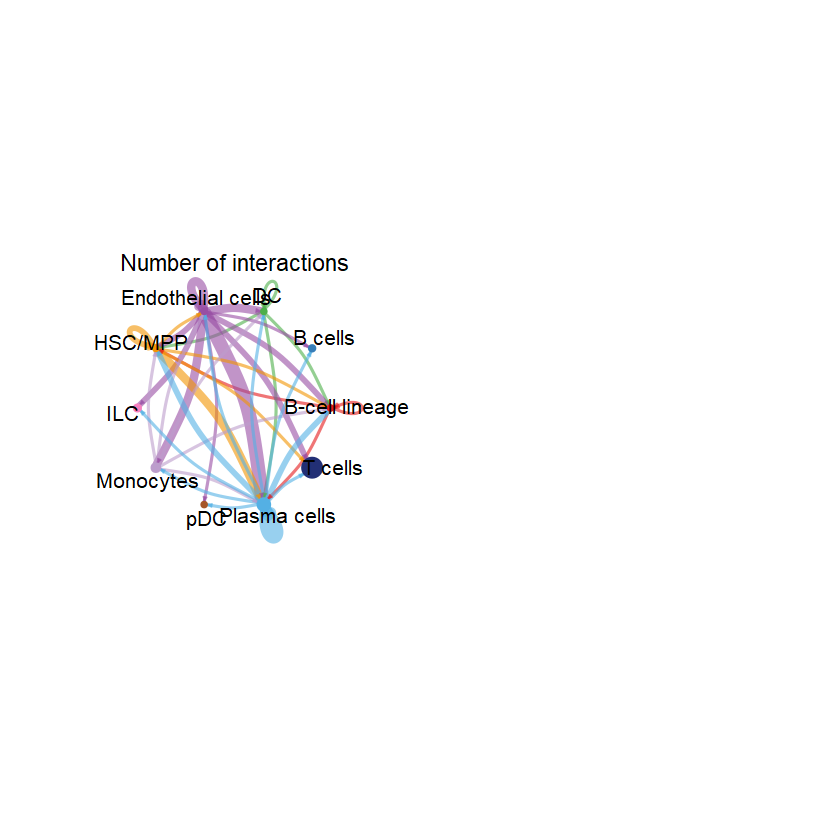

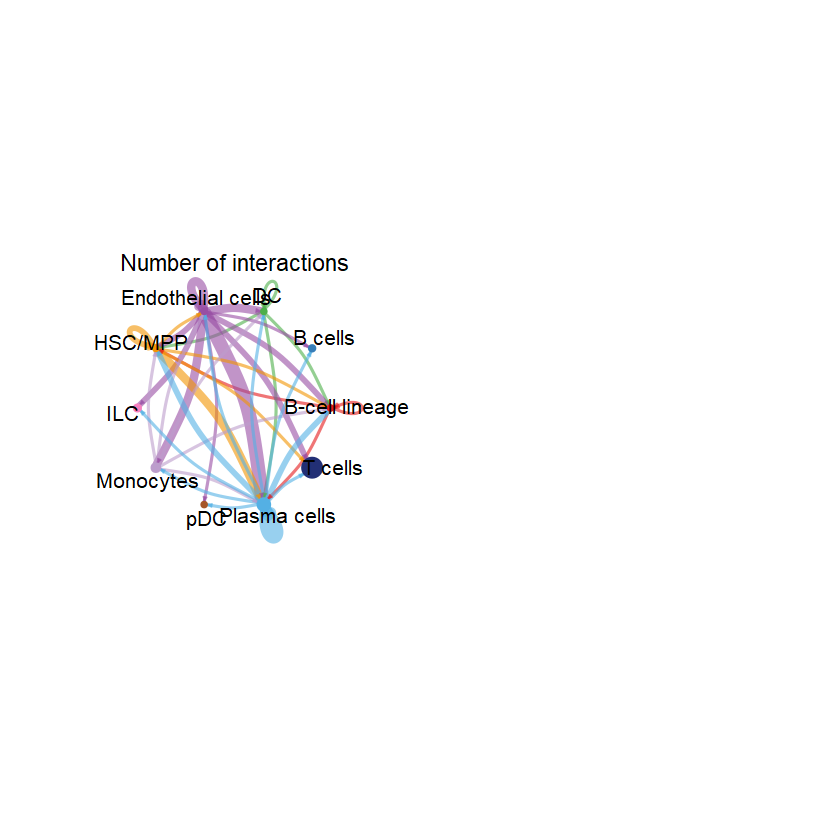

In [81]:
#showing the number of interactions:
par(mfrow = c(1,2), xpd=TRUE) # Display 1 row 2 column / xpd = true all plotting is clipped to the figure region,
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, 
                 weight.scale = T, label.edge= F, 
                 title.name = "Number of interactions")

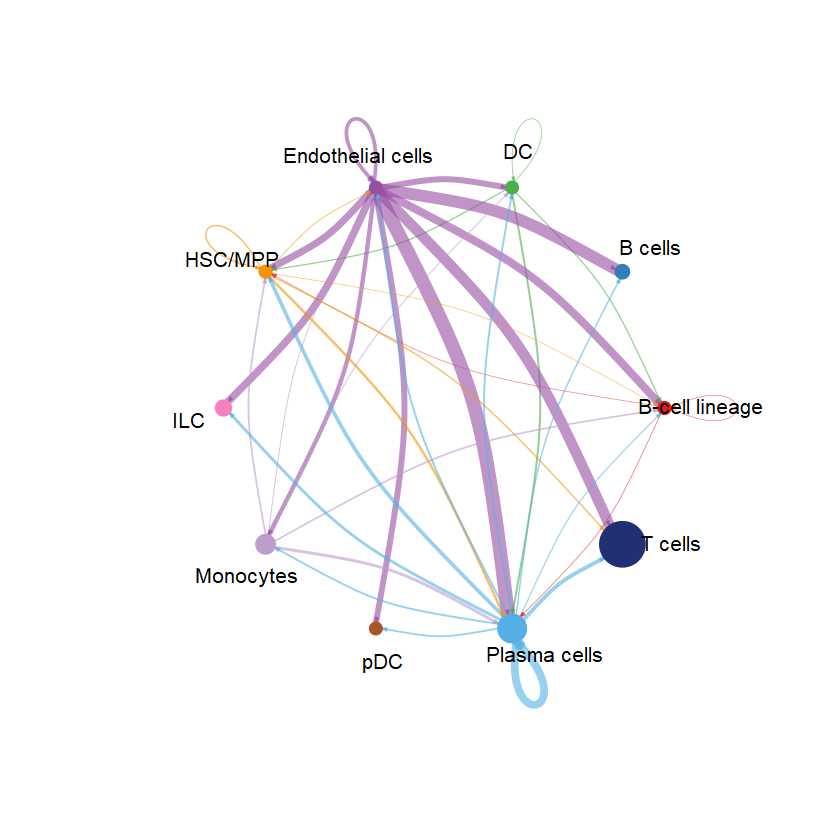

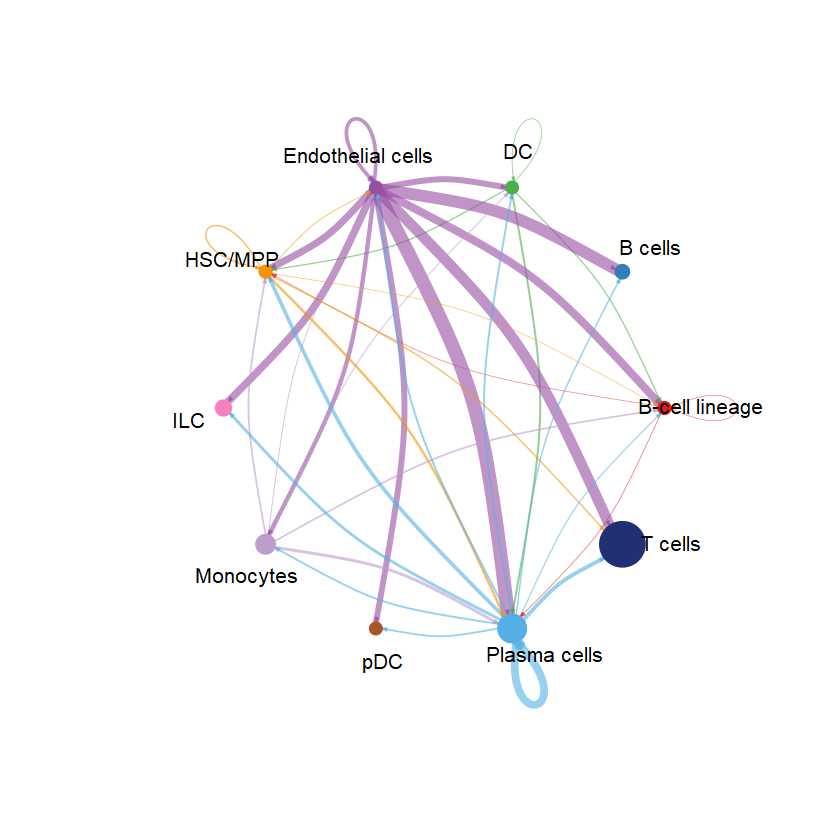

In [82]:
#Showing the total interaction strength (weights) between any two cell groups:
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, 
                 weight.scale = T, label.edge= F, 
                 title.name = "Interaction weights/strength")

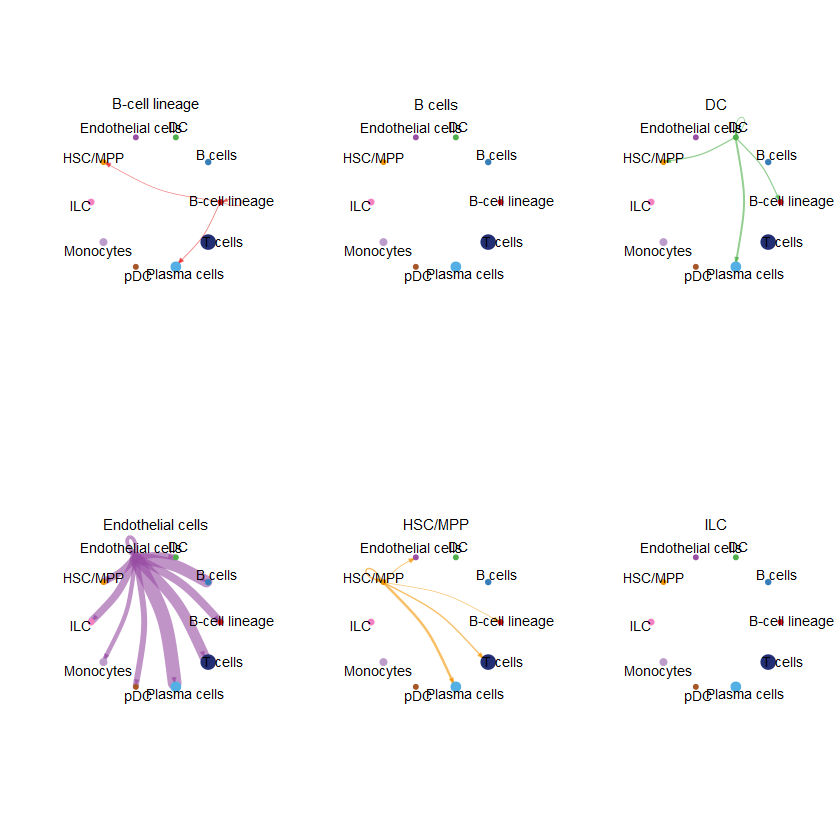

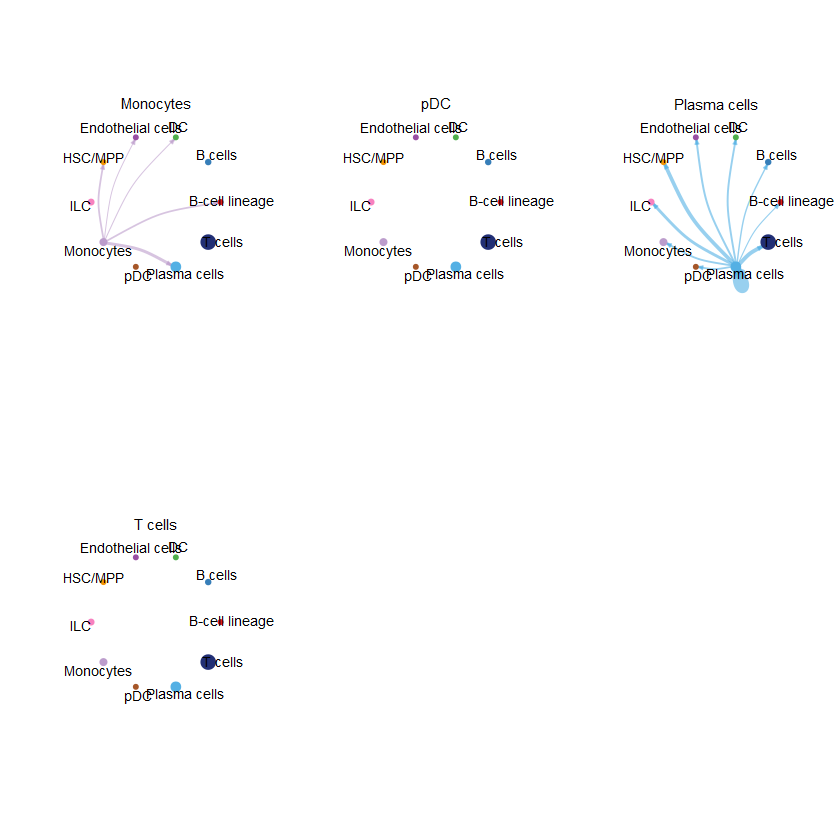

In [83]:
#Due to the complicated cell-cell communication network, we can examine the signaling sent from each cell group. 
#By controlling the parameter edge.weight.max,edge weights between different networks can be compared.
mat <- cellchat@net$weight
par(mfrow = c(2,3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

In [84]:
# # Part III: Visualization of cell-cell communication network  -----------

#Visualize each signaling pathway using Circle plot, Chord diagram or heat map
cellchat@netP$pathways #All the signaling pathways showing significant communications  
pathways.show <- c("VISFATIN")

[1] "CXCL"     "MK"       "VISFATIN" "CCL"

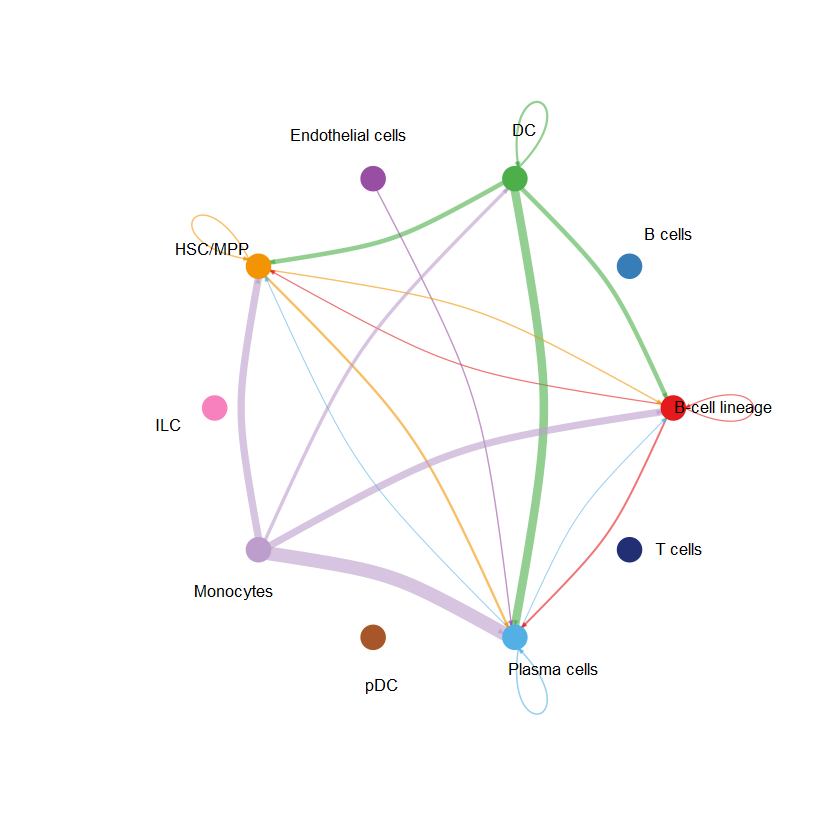

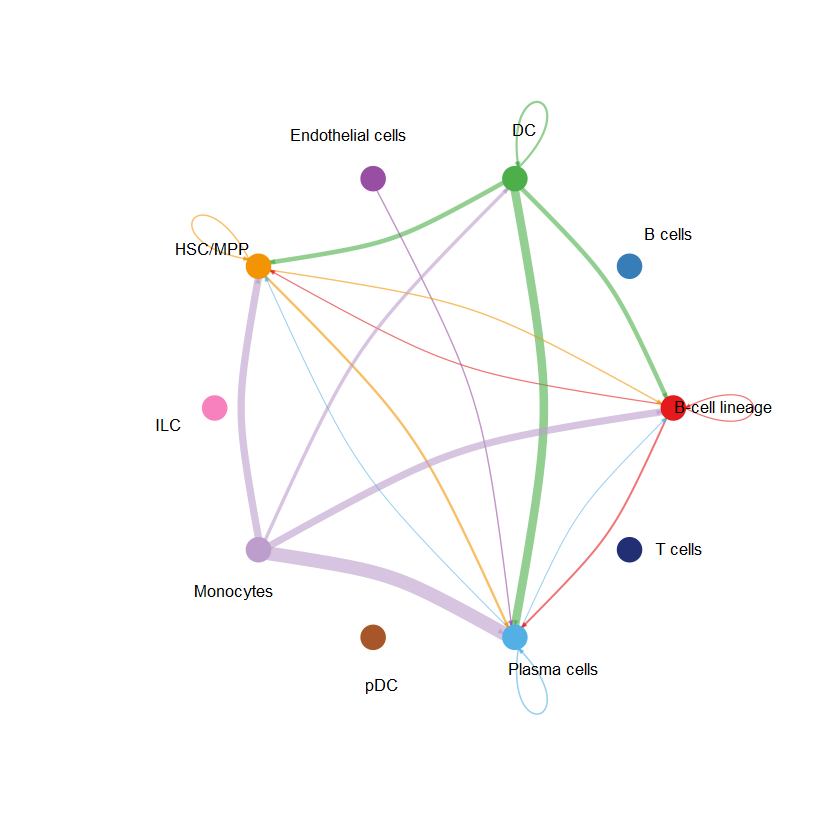

In [85]:
#1- Circle plot
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")

In [86]:
pdf(file ="cellchat_chordplot.pdf", width = 20, height =16)


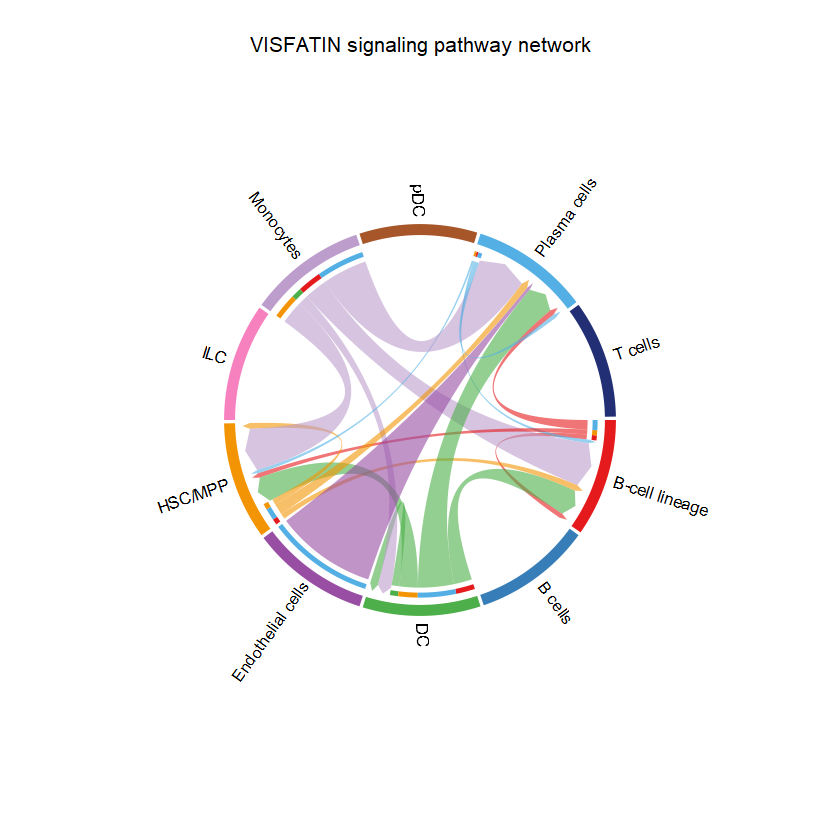

pdf 
  3

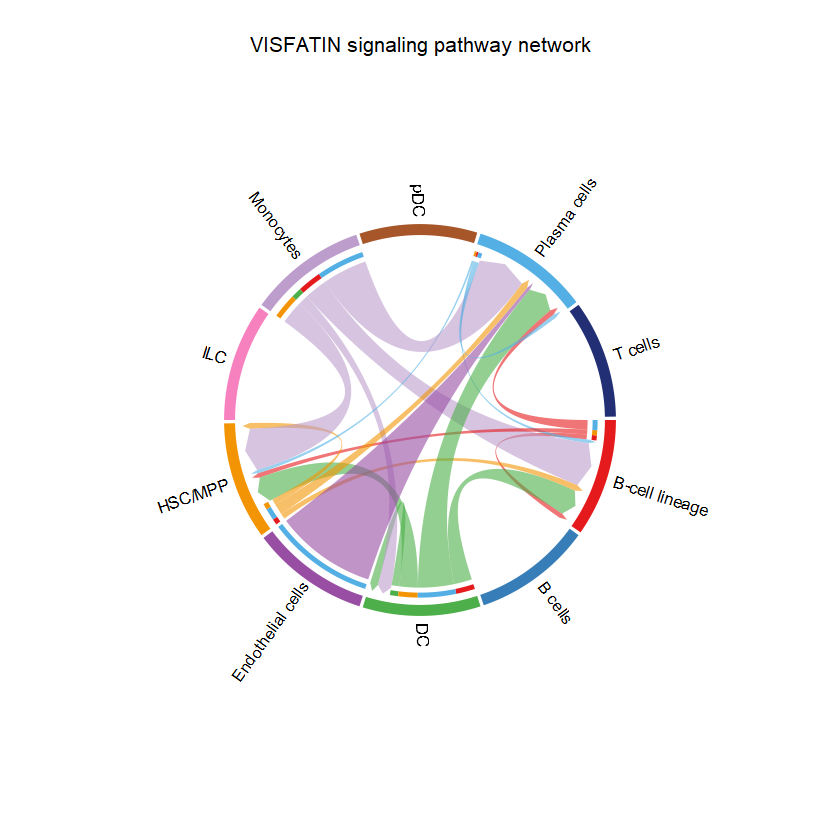

In [87]:
#2-Chord diagram
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
dev.off()

In [112]:
#3-Heat map
par(mfrow=c(1,1))
netVisual_heatmap(cellchat, signaling = "MK", color.heatmap = "Reds")

Do heatmap based on a single object 




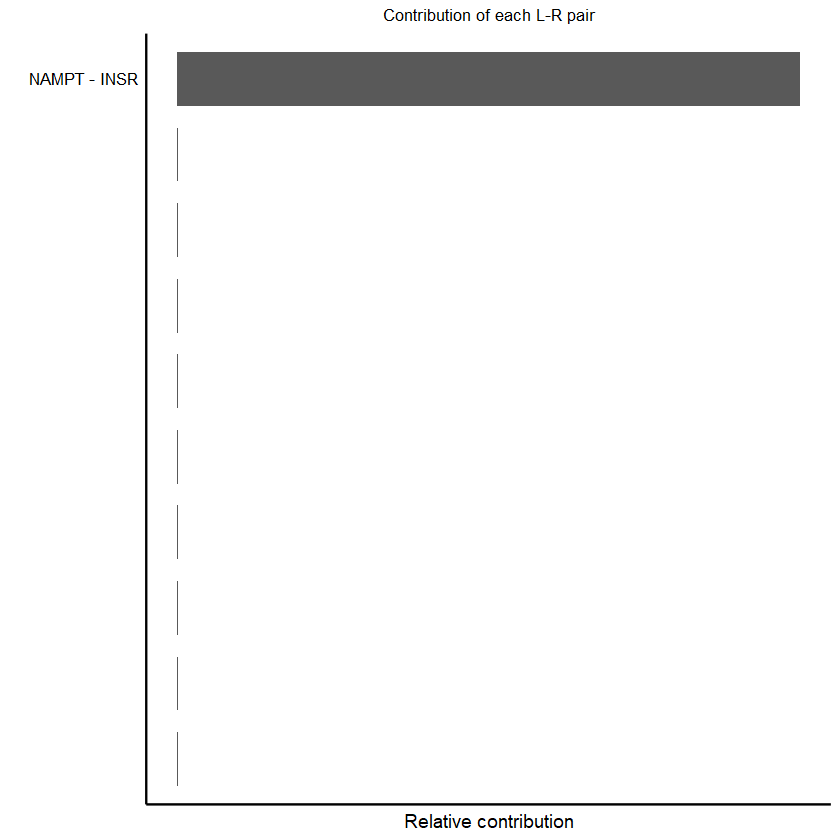

In [89]:
#Compute the contribution of each ligand-receptor pair to the overall signaling 
netAnalysis_contribution(cellchat, signaling = pathways.show) 

#visualize the cell-cell communication mediated by a single ligand-receptor pair. 
#The function EnrichedLR extracts all the significant interactions (L-R pairs) and related signaling genes for a given signaling pathway.
pairLR.EGVF <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
LR.show <- pairLR.EGVF[1,] # show one ligand-receptor pair

[[1]]


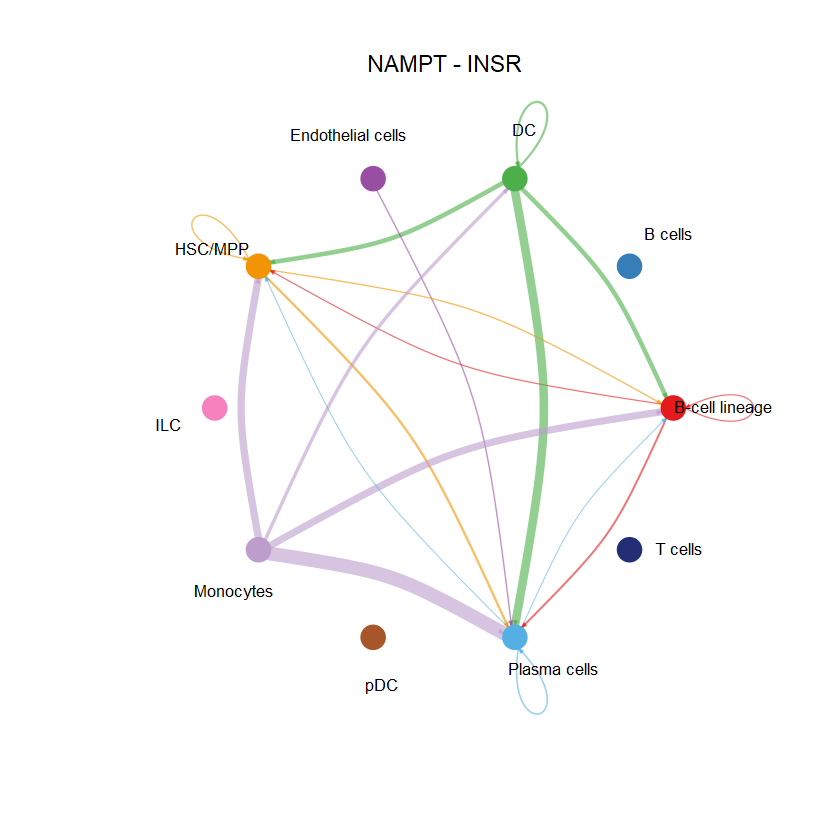

In [90]:
# Circle plot
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "circle")

In [91]:
pdf(file ="Ligand_receptor_Gelation.pdf", width = 20, height =16)
# Chord diagram
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "chord")
dev.off()

[[1]]


png 
  2

In [92]:
# Access all the signaling pathways showing significant communications
pathways.show.all <- cellchat@netP$pathways
# check the order of cell identity to set suitable vertex.receiver
levels(cellchat@idents)
vertex.receiver = seq(1,2)
for (i in 1:length(pathways.show.all)) {
  # Visualize communication network associated with both signaling pathway and individual L-R pairs
  netVisual(cellchat, signaling = pathways.show.all[i], vertex.receiver = vertex.receiver, layout = "hierarchy")
  # Compute and visualize the contribution of each ligand-receptor pair to the overall signaling pathway
  gg <- netAnalysis_contribution(cellchat, signaling = pathways.show.all[i])
  ggsave(filename=paste0(pathways.show.all[i], "_L-R_contribution.pdf"), plot=gg, width = 3, height = 2, units = 'in', dpi = 300)
}

[1] "B-cell lineage"    "B cells"           "DC"               
 [4] "Endothelial cells" "HSC/MPP"           "ILC"              
 [7] "Monocytes"         "pDC"               "Plasma cells"     
[10] "T cells"

Comparing communications on a single object 




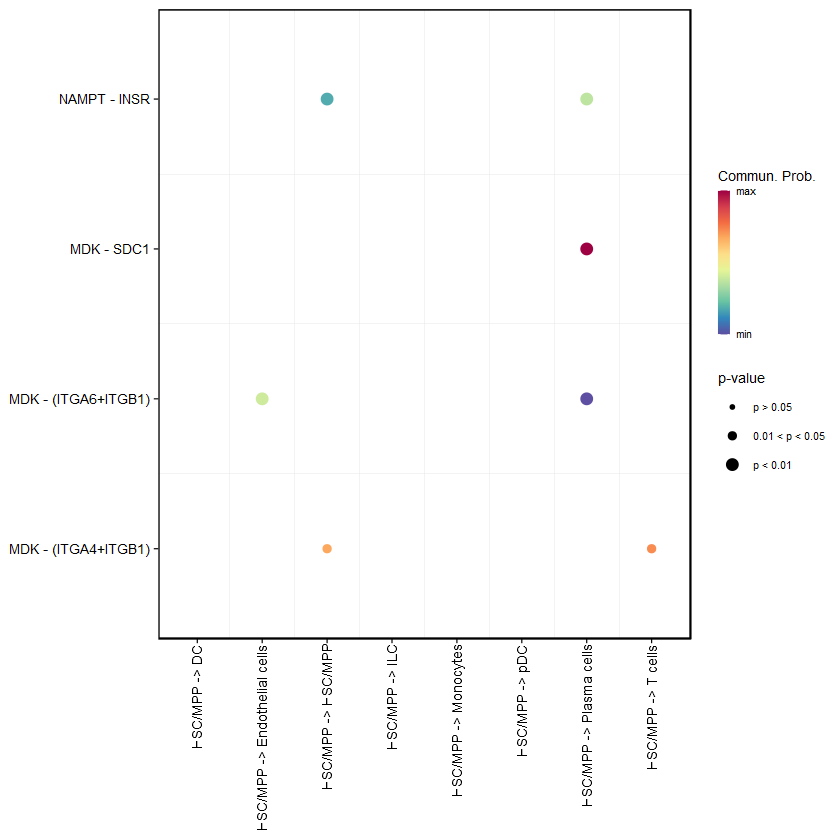

In [93]:
##Visualize cell-cell communication mediated by MULTIPLE LIGAND-RECEPTORS or signaling pathways
#a-Bubble plot 
# show all the significant interactions (L-R pairs) from some cell groups (defined by 'sources.use' Macro) to other cell groups (defined by 'targets.use' all)
#1) HSC/MPP
netVisual_bubble(cellchat, sources.use =5 , targets.use = c(3:10), remove.isolate = FALSE)
#> Comparing communications on a single object

Comparing communications on a single object 




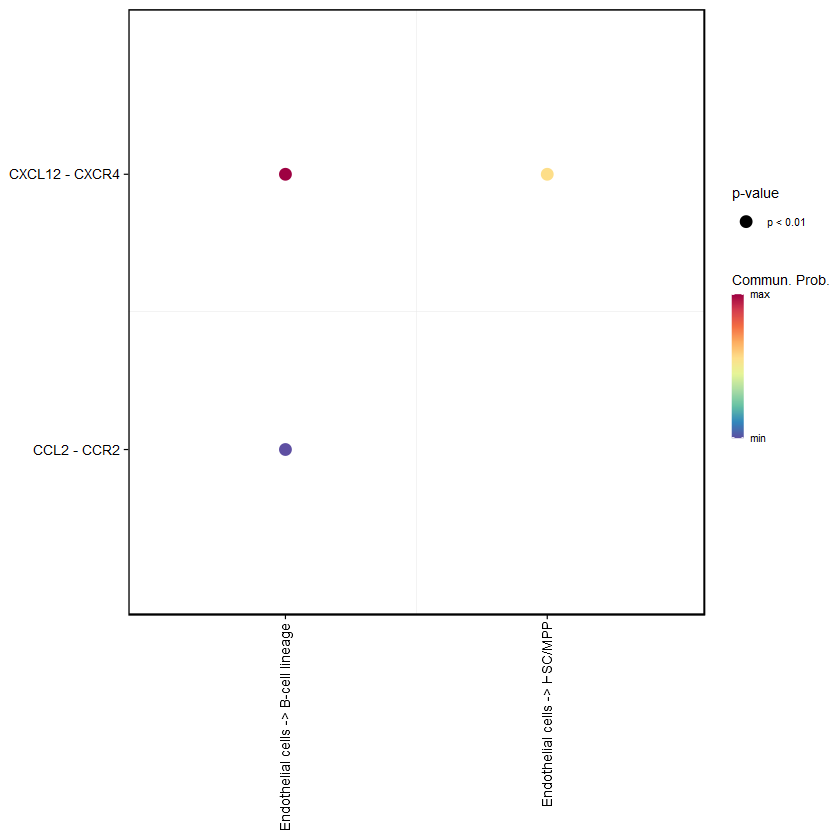

In [100]:
#########1)HSC/MPP

# show all the significant interactions (L-R pairs) associated with certain signaling pathway (APRIL)
netVisual_bubble(cellchat, sources.use = 4, targets.use = c(1, 5), signaling = c("CXCL", "CCL"), remove.isolate = FALSE)


Comparing communications on a single object 




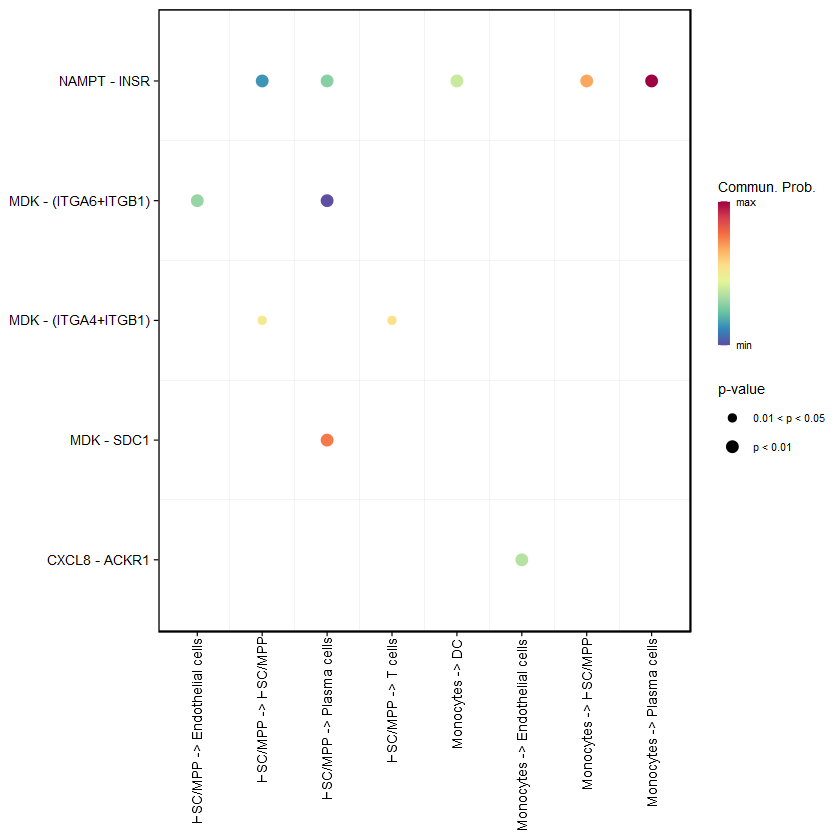

In [101]:
# show all the significant interactions (L-R pairs) based on user's input (defined by `pairLR.use`)
pairLR.use <- extractEnrichedLR(cellchat, signaling = c("CCL","CXCL", "MK","VISFATIN"))
netVisual_bubble(cellchat, sources.use = c(5,7), targets.use = c(3:10), pairLR.use = pairLR.use, remove.isolate = TRUE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


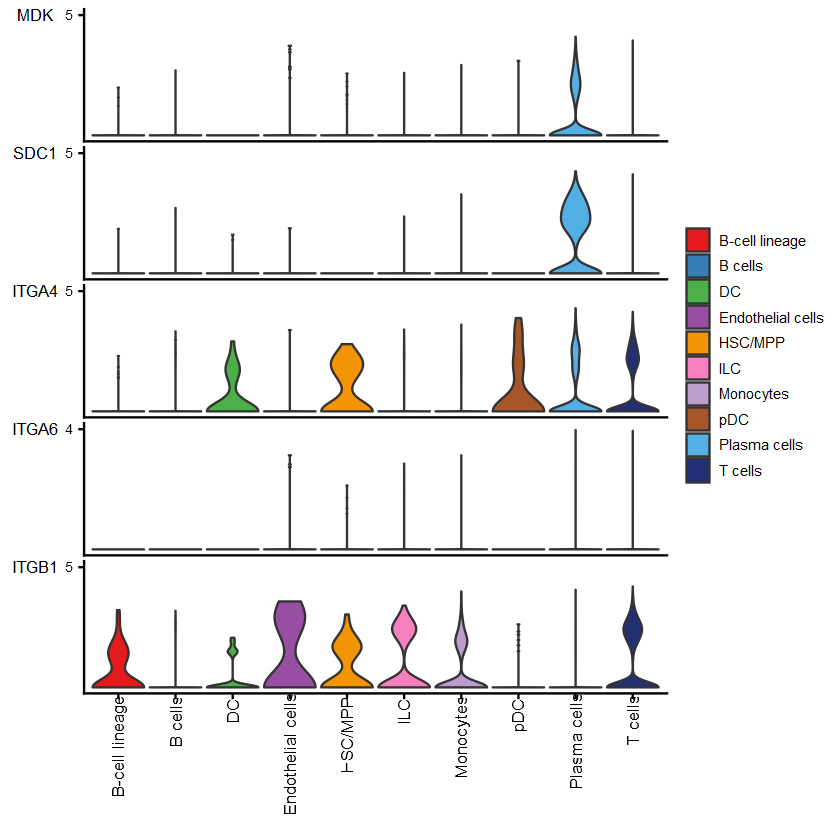

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


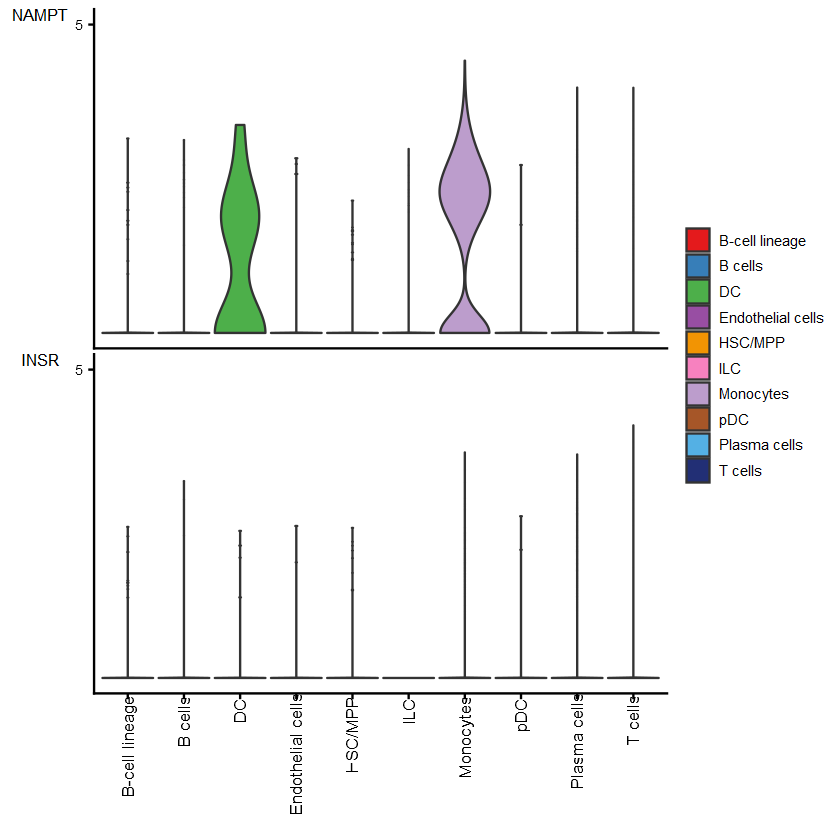

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


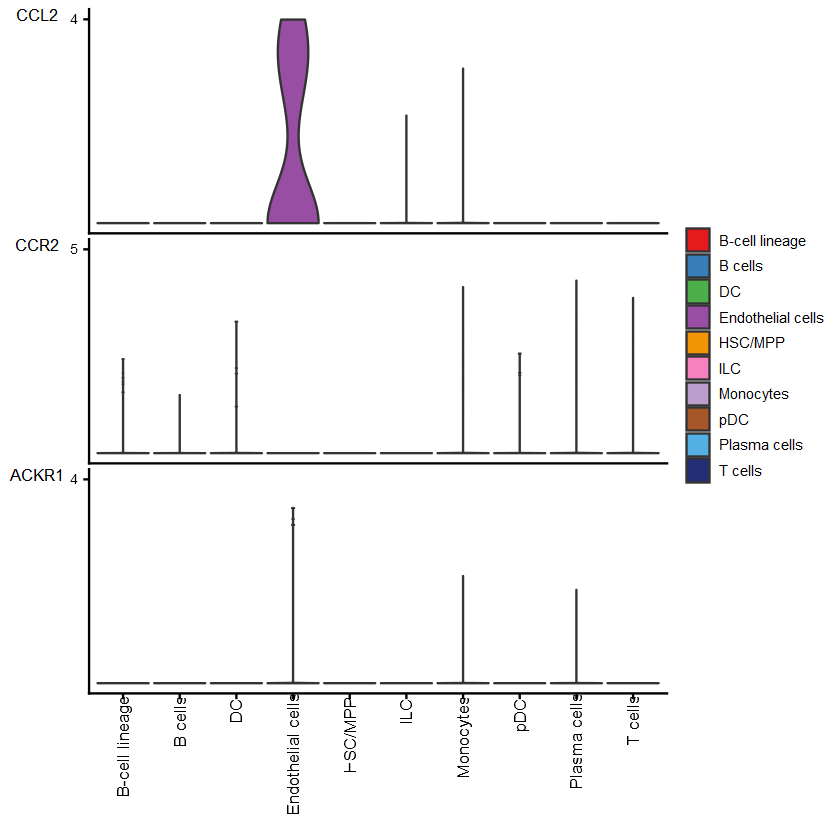

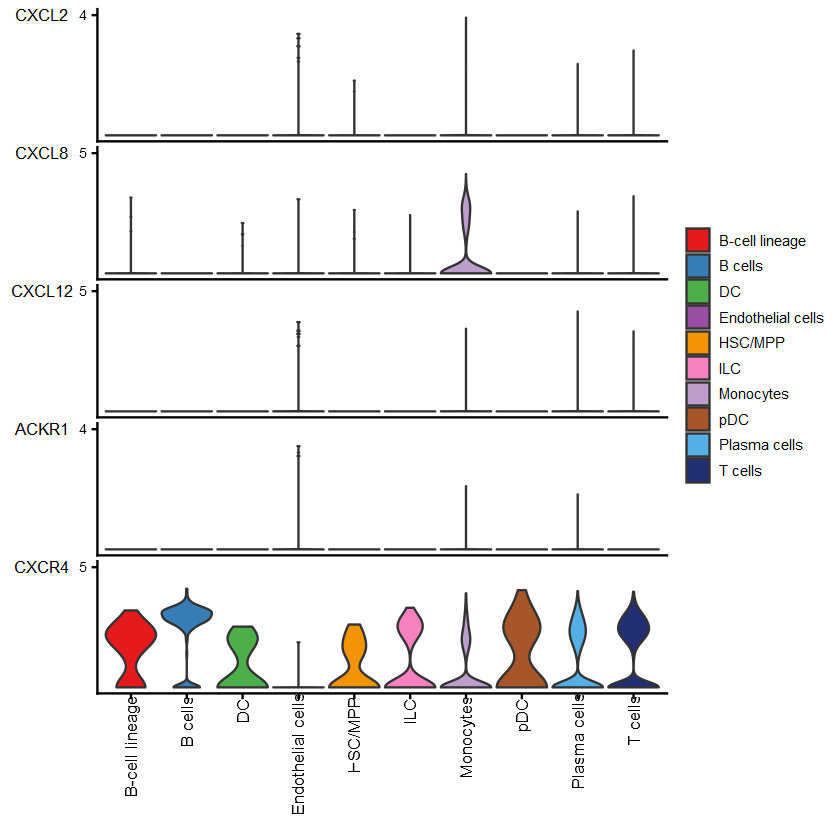

In [104]:
#c-Plot the signaling gene expression distribution using violin/dot plot
plotGeneExpression(cellchat, signaling = "MK")
plotGeneExpression(cellchat, signaling = "VISFATIN")
plotGeneExpression(cellchat, signaling = "CCL")
plotGeneExpression(cellchat, signaling = "CXCL")
#plotGeneExpression(cellchat, signaling = "CALCR")
#plotGeneExpression(cellchat, signaling = "GALECTIN")


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

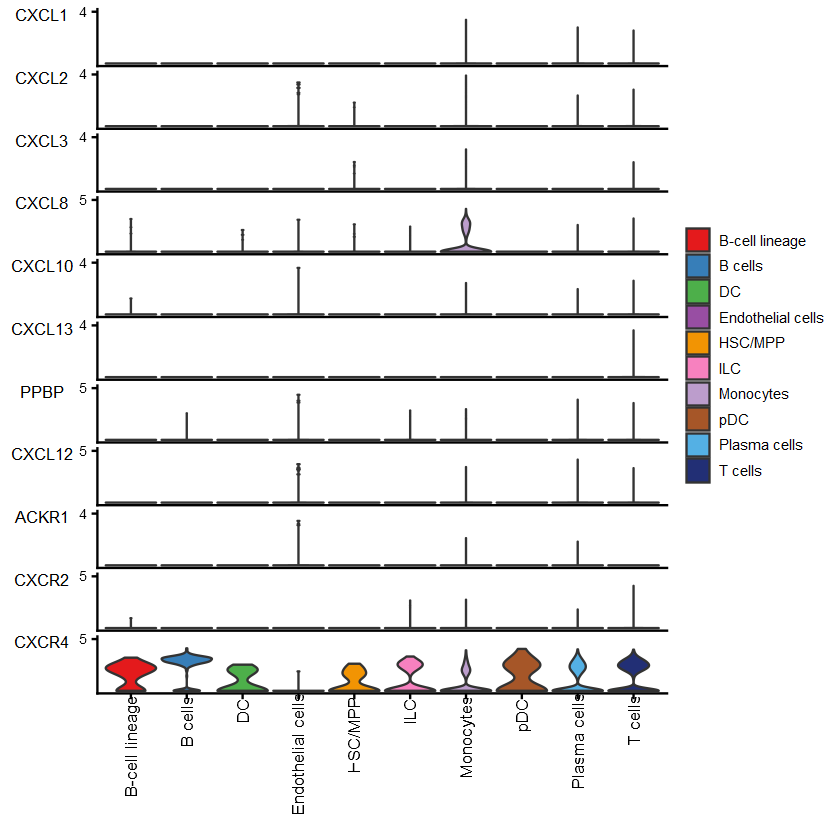

In [105]:
#show the expression of all signaling genes related to one signaling pathway
plotGeneExpression(cellchat, signaling = "CXCL", enriched.only = FALSE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


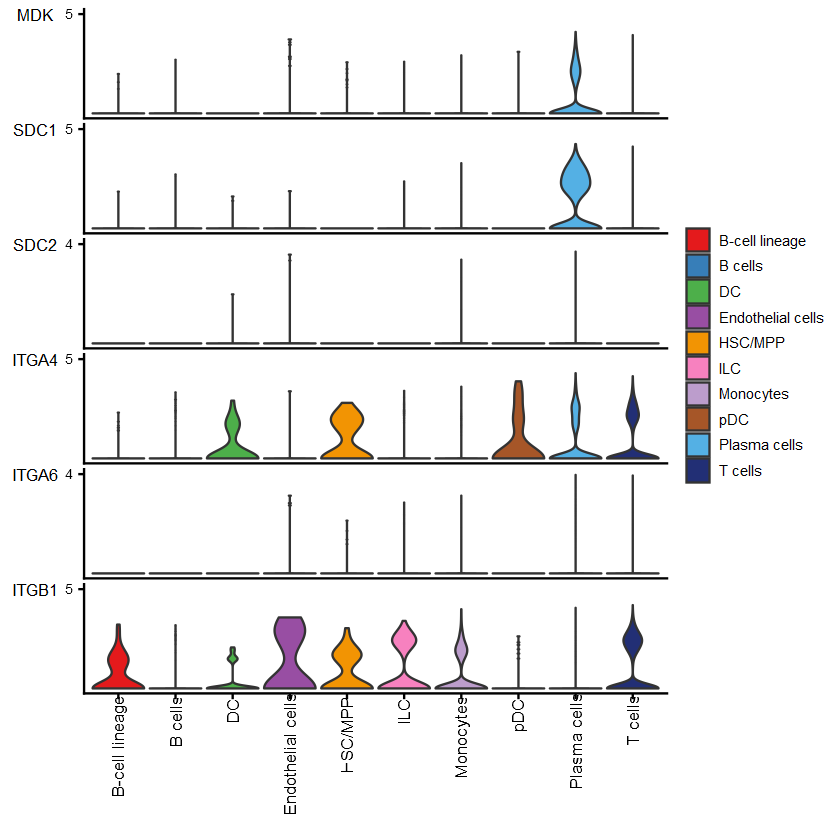

In [106]:
#show the expression of all signaling genes related to one signaling pathway
#"GALECTIN" "MK"       "BAFF"     "CXCL"     "VISFATIN" "CCL"      "TNF"      "CALCR"   
plotGeneExpression(cellchat, signaling = "MK", enriched.only = FALSE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

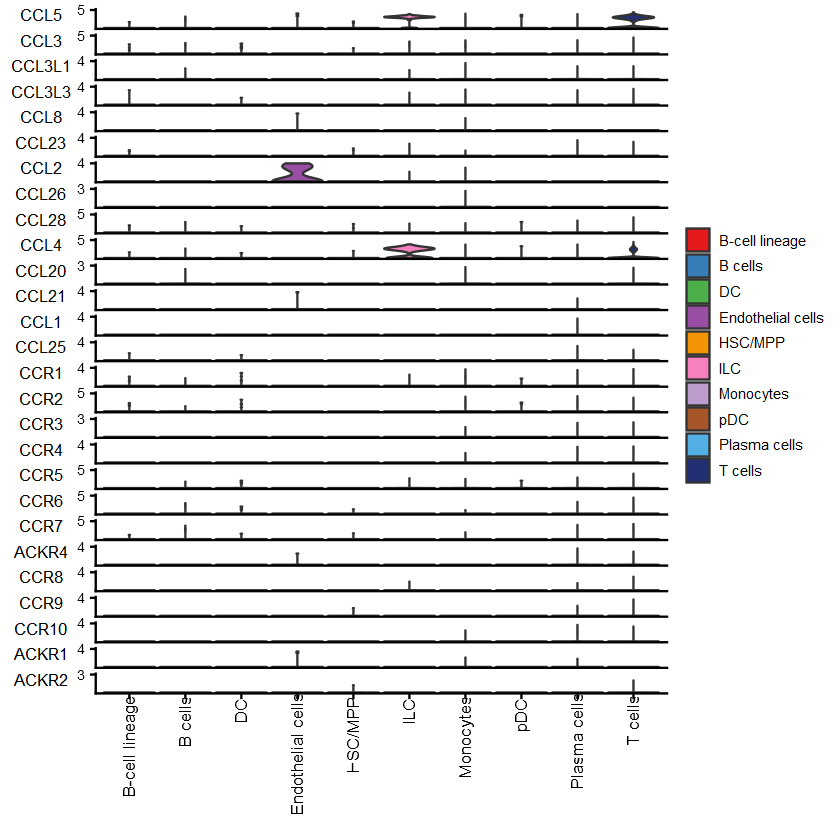

In [49]:
#"GALECTIN" "MK"       "BAFF"     "CXCL"     "VISFATIN" "CCL"      "TNF"      "CALCR"   
plotGeneExpression(cellchat, signaling = "CCL", enriched.only = FALSE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


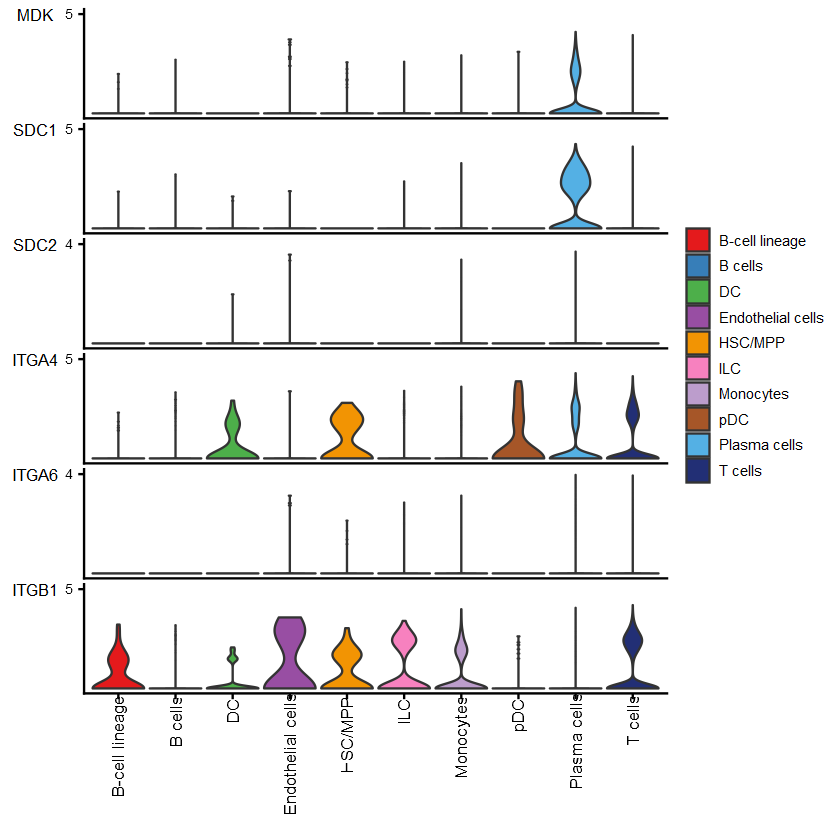

In [107]:
plotGeneExpression(cellchat, signaling = "MK", enriched.only = FALSE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


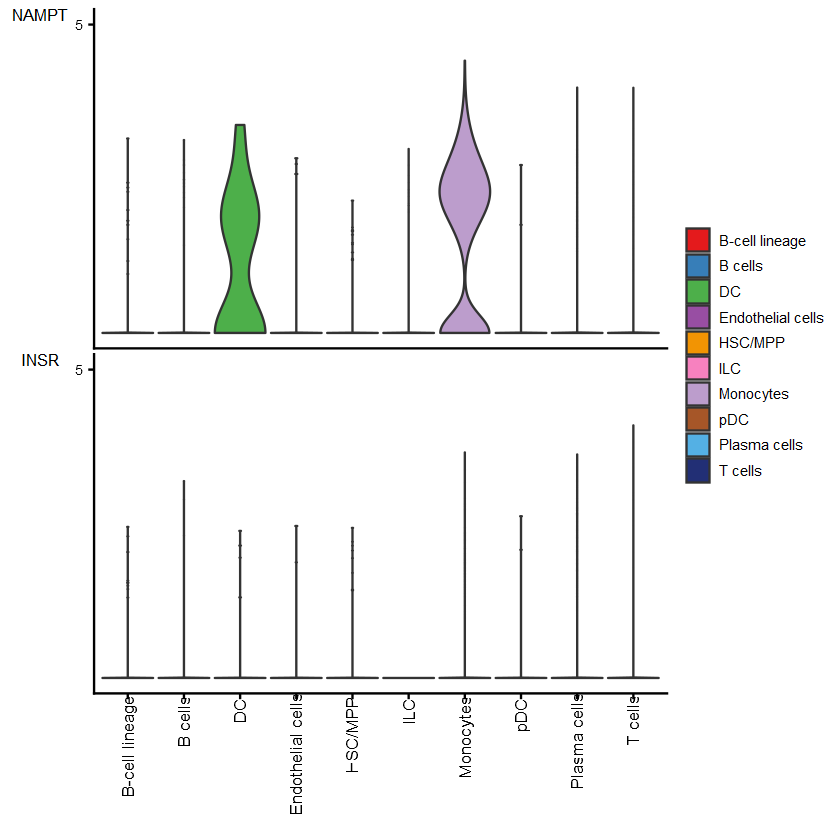

In [108]:
#"GALECTIN" "MK"       "BAFF"     "CXCL"     "VISFATIN" "CCL"      "TNF"      "CALCR"   
plotGeneExpression(cellchat, signaling = "VISFATIN", enriched.only = FALSE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

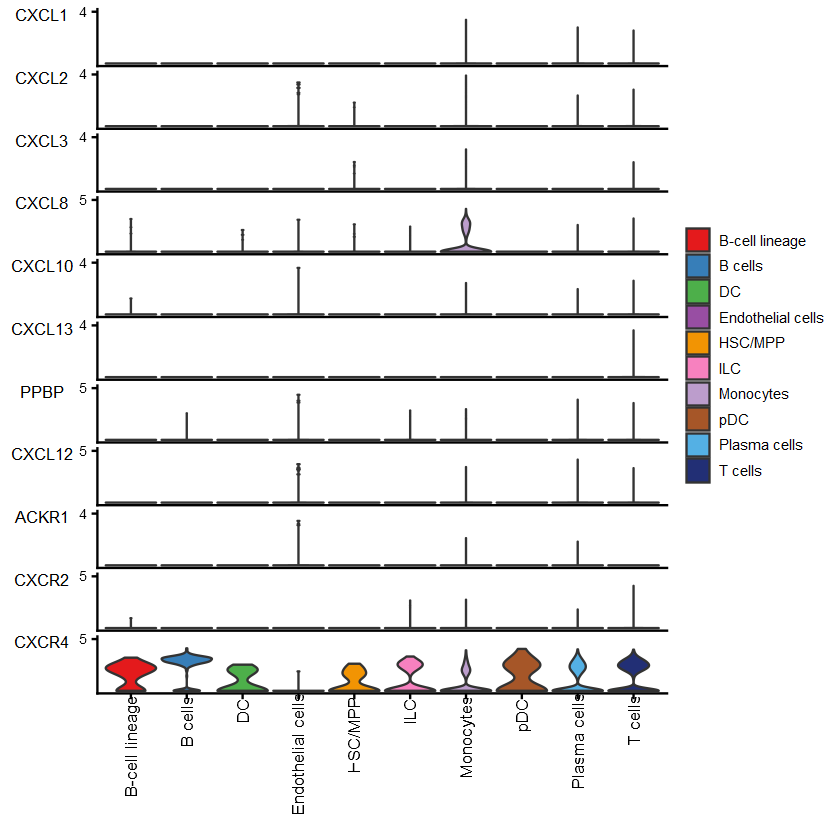

In [109]:
#"GALECTIN" "MK"       "BAFF"     "CXCL"     "VISFATIN" "CCL"      "TNF"      "CALCR"   
plotGeneExpression(cellchat, signaling = "CXCL", enriched.only = FALSE)

In [110]:
#"GALECTIN" "MK"       "BAFF"     "CXCL"     "VISFATIN" "CCL"      "TNF"      "CALCR"   
#plotGeneExpression(cellchat, signaling = "TNF", enriched.only = FALSE)

In [111]:
# # Part V: Save the CellChat object- -------------------------------------

saveRDS(cellchat, file = "cellchat_Multiple_Myeloma_LS.rds")